Fallstudie:<br> 
**Erstellen eines Prognosemodells des Kreditkartenzahlungsverkehr für Online-Einkäufe**


In [1]:
import pandas as pd
pd.option_context('mode.use_inf_as_na', True)
pd.set_option('display.max_columns', 100)
import warnings
warnings.simplefilter("ignore", category=FutureWarning)
import datetime as dt
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style='darkgrid',)
color_pal = sns.color_palette("muted")
sns.set_palette(color_pal)
sns.set_context("paper")

%matplotlib inline

# Business understanding
**Aktuelle Situation:**<br>
- Einzelhandelsunternehmen hat Verträge mit 4 versch. payment service provider (PSP) für Online-Kreditkartenzahlungen
- Auswahl eines PSPs für eine Überweisung erfolgt auf Basis eines fixen Regelwerks
- Ausfallrate an Online-Kreditkartenzahlungen ist hoch
- Konsequenz: hohe Kosten für das Unternehmen und unzufriedene Kunden

**Geschäftsziele:**<br>
- Ablösen des fixen, manuellen Regelwerks durch ein Prognosemodell zur Auswahl eines PSPs für eine Zahlung
- Verbesserung der Erfolgsrate der Transaktionen
- Reduzierung der Transaktionskosten

**Erfolgskriterien:**<br>
- höhere Erfolgsrate der Transaktionen (first time through)
- und niedrigere Transaktionskosten gegenüber der aktuellen Situation

# Data understanding

## Collect initial data
**Hauptdatensatz:**<br>
Initialer Datensatz vom Januar und Februar 2019 mit den Kreditkartentransaktionen der DACH Länder<br>

**Kostendaten:**<br>
Transaktionskosten für erfolgreiche und fehlgeschlagene Transaktionen je PSP

In [2]:
# transactions
df_t_in = pd.read_excel("../data/01_raw/PSP_Jan_Feb_2019.xlsx").set_index(keys="Unnamed: 0", drop=True)

In [3]:
df_t_in.head()

,tmsp,country,amount,success,PSP,3D_secured,card
Unnamed: 0,,,,,,,
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners


In [4]:
# cost data
cost_dict = {"PSP_name": ["Moneycard", "Goldcard", "UK_Card", "Simplecard"], 
             "fee_success_EUR": [5, 10, 3, 1], 
             "fee_failed_EUR": [2, 5, 1, 0.5]}
df_cost_in = pd.DataFrame(cost_dict, columns=["PSP_name", "fee_success_EUR", "fee_failed_EUR"])

In [5]:
df_cost_in.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PSP_name         4 non-null      object 
 1   fee_success_EUR  4 non-null      int64  
 2   fee_failed_EUR   4 non-null      float64
dtypes: float64(1), int64(1), object(1)
memory usage: 228.0+ bytes


## Describe data
6 unabhängige Variablen und 1 Zielvariable (success) mit knapp 50.000 Datensätzen<br>
Datenformat korrekt erkannt<br>
keine fehlenden Werte<br>

In [6]:
df_t_in.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50410 entries, 0 to 50409
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   tmsp        50410 non-null  datetime64[ns]
 1   country     50410 non-null  object        
 2   amount      50410 non-null  int64         
 3   success     50410 non-null  int64         
 4   PSP         50410 non-null  object        
 5   3D_secured  50410 non-null  int64         
 6   card        50410 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 3.1+ MB


In [7]:
df_t_in.describe()

,tmsp,amount,success,3D_secured
count,50410,50410.000000,50410.000000,50410.000000
mean,2019-01-29 16:28:52.923269120,202.395715,0.202896,0.238266
min,2019-01-01 00:01:11,6.000000,0.000000,0.000000
25%,2019-01-14 12:00:36.249999872,133.000000,0.000000,0.000000
50%,2019-01-30 15:20:07.500000,201.000000,0.000000,0.000000
75%,2019-02-13 01:09:50.500000,269.000000,0.000000,0.000000
max,2019-02-28 23:48:19,630.000000,1.000000,1.000000
std,NaN,96.274730,0.402160,0.426027


In [20]:
# dictionary to rename columns
rename_cols = {"tmsp":"x_tmsp", 
               "country":"x_country", 
               "amount":"x_amount", 
               "PSP":"x_psp", 
               "3D_secured":"x_3d_secured", 
               "card":"x_card", 
               "success":"y_success"}

df_t_in.rename(columns=rename_cols, inplace=True)

# raw x- and y-variables
x_raw = [x for x in list(df_t_in.columns) if x.find("x_")!=-1]
y_raw = [y for y in list(df_t_in.columns) if y.find("y_")!=-1]

## Explore data

In [12]:
# plot dimensions
plot_width = 15
plot_height = 5
palette_success ={0: color_pal[1], 1: color_pal[2]}

### Verteilung über Histogramme

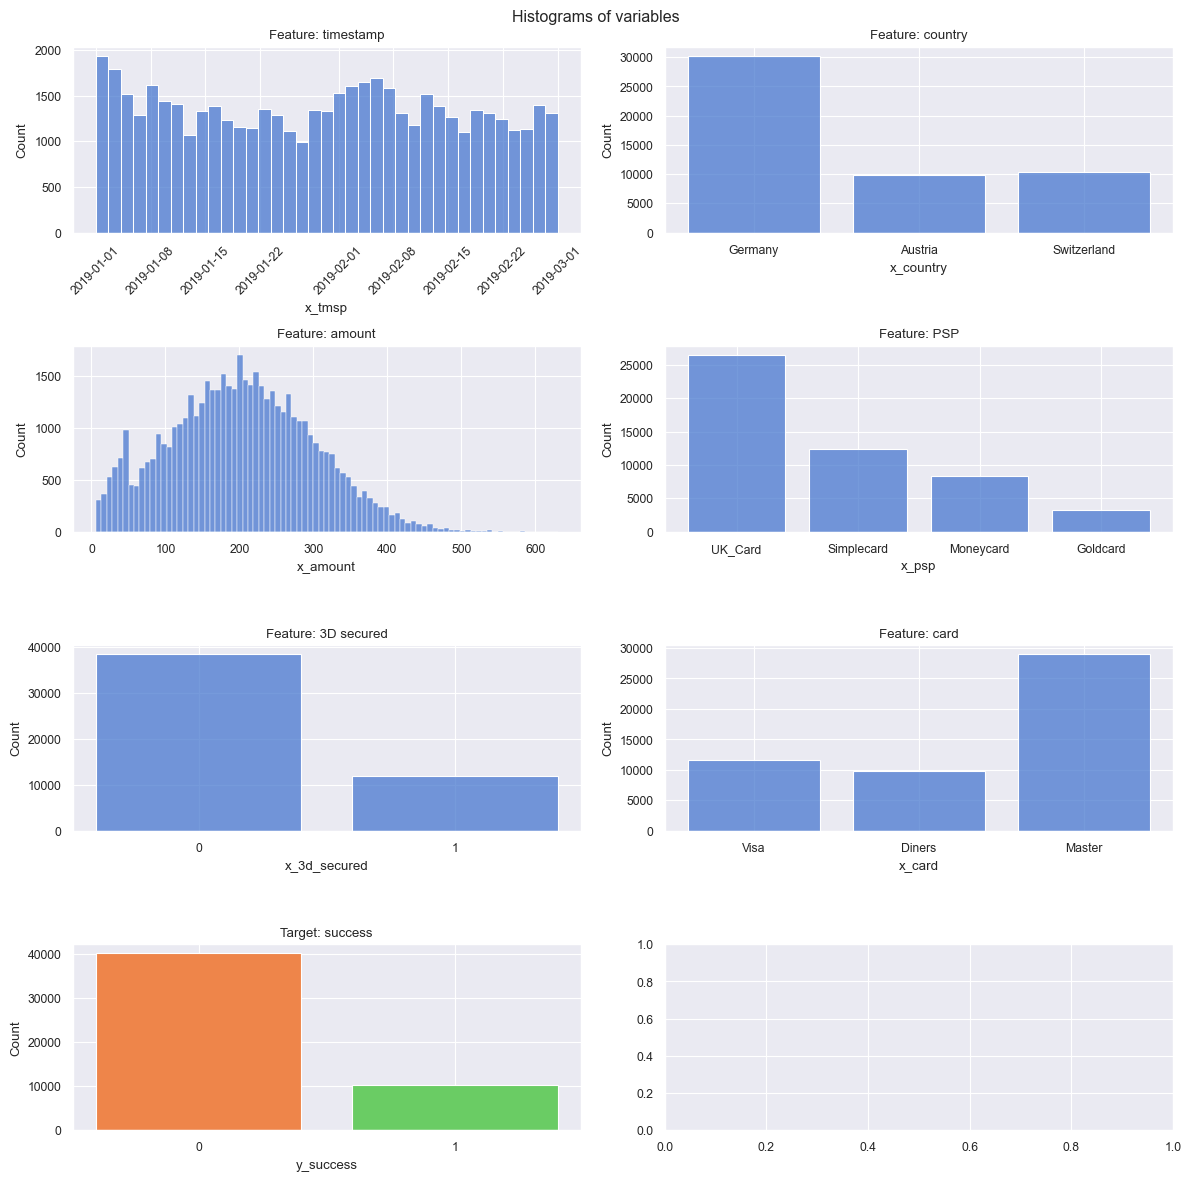

In [10]:
fig, axs = plt.subplots(4,2, figsize=(12, 12), sharex=False, tight_layout=True)

# Timestamp
sns.histplot(df_t_in, x="x_tmsp", stat="count", ax=axs[0, 0])
axs[0, 0].set_title("Feature: timestamp")
for label in axs[0, 0].get_xticklabels():
    label.set_rotation(45)

# Country
sns.histplot(df_t_in, x="x_country", discrete=True, shrink=.8, stat="count", ax=axs[0, 1])
axs[0, 1].set_title("Feature: country")

# Amount
sns.histplot(df_t_in, x="x_amount", stat="count", ax=axs[1, 0])
axs[1, 0].set_title("Feature: amount")

# PSP
sns.histplot(df_t_in, x="x_psp", discrete=True, shrink=.8, stat="count", ax=axs[1, 1])
axs[1, 1].set_title("Feature: PSP")

# 3d_secured
sns.histplot(df_t_in, x="x_3d_secured", discrete=True, shrink=.8, stat="count", ax=axs[2, 0])
axs[2, 0].set_xticks(range(0,2))
axs[2, 0].set_title("Feature: 3D secured")

# card
sns.histplot(df_t_in, x="x_card", discrete=True, shrink=.8, stat="count", ax=axs[2, 1])
axs[2, 1].set_title("Feature: card")

# card
sns.histplot(df_t_in, x="y_success", discrete=True, shrink=.8, stat="count", ax=axs[3, 0])
axs[3, 0].set_xticks(range(0,2))
axs[3, 0].set_title("Target: success")
axs[3, 0].patches[0].set_facecolor(color_pal[1])
axs[3, 0].patches[1].set_facecolor(color_pal[2])

plt.subplots_adjust(hspace=0.3, top = 0.93, bottom = 0.02) 
fig.suptitle("Histograms of variables") 
plt.show() 
plt.close()

> Amount muss genauer angeschaut werden, da es hier einige Ausreißer nach oben gibt

<Figure size 1500x500 with 0 Axes>

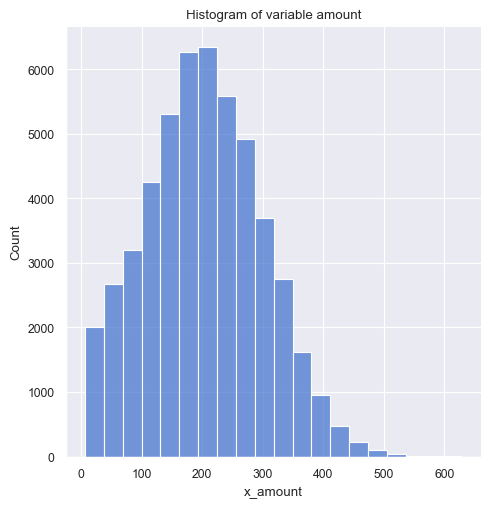

In [13]:
plt.figure(figsize=(plot_width, plot_height))
sns.displot(df_t_in, x="x_amount", bins=20)
plt.title("Histogram of variable amount")
plt.show()
plt.close()

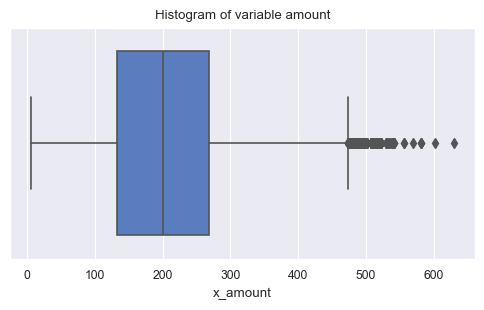

In [14]:
plt.figure(figsize=(6, 3))
sns.boxplot(x="x_amount", orient="h", data=df_t_in)
plt.title("Histogram of variable amount")
plt.show()
plt.close()

Findings:
> Outliers bei Amount: > 500 EUR stehe nur noch sehr wenige Datensätze zur Verfügung. <br>
> Success: Es gibt mehr fehlgeschlagene Versuche, als erfolgreiche Versuche. Daher muss es sehr viele Mehrfachversuche geben, die identifiziert werden müssen.

### Korrelation überprüfen
Es liegt mit "amount" nur sehr wenige numerische Variablen vor, wobei nur die Variable "amount" kontinuierliche Daher kann die Korrelation auch nur begrenzt bewertet werden.<br>
Bei den Korrelation ist wie erwartet sehr schwach, da auch nur sehr wenige numerische Wert

In [15]:
corr_pearson_raw = df_t_in.corr(method="pearson", numeric_only=True)
corr_pearson_raw

,x_amount,y_success,x_3d_secured
x_amount,1.000000,-0.086423,0.000178
y_success,-0.086423,1.000000,0.059284
x_3d_secured,0.000178,0.059284,1.000000


<Axes: >

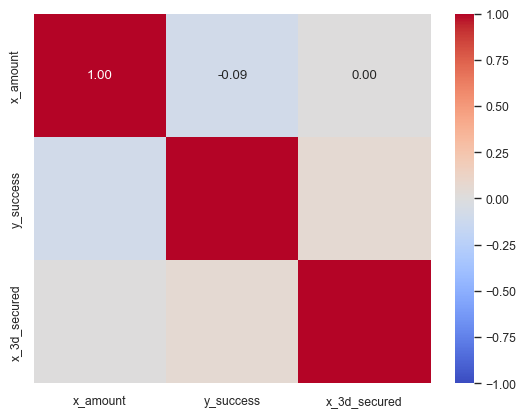

In [16]:
sns.heatmap(corr_pearson_raw, annot=True, vmin=-1, vmax=1, center=0.0, fmt=".2f", cmap="coolwarm")

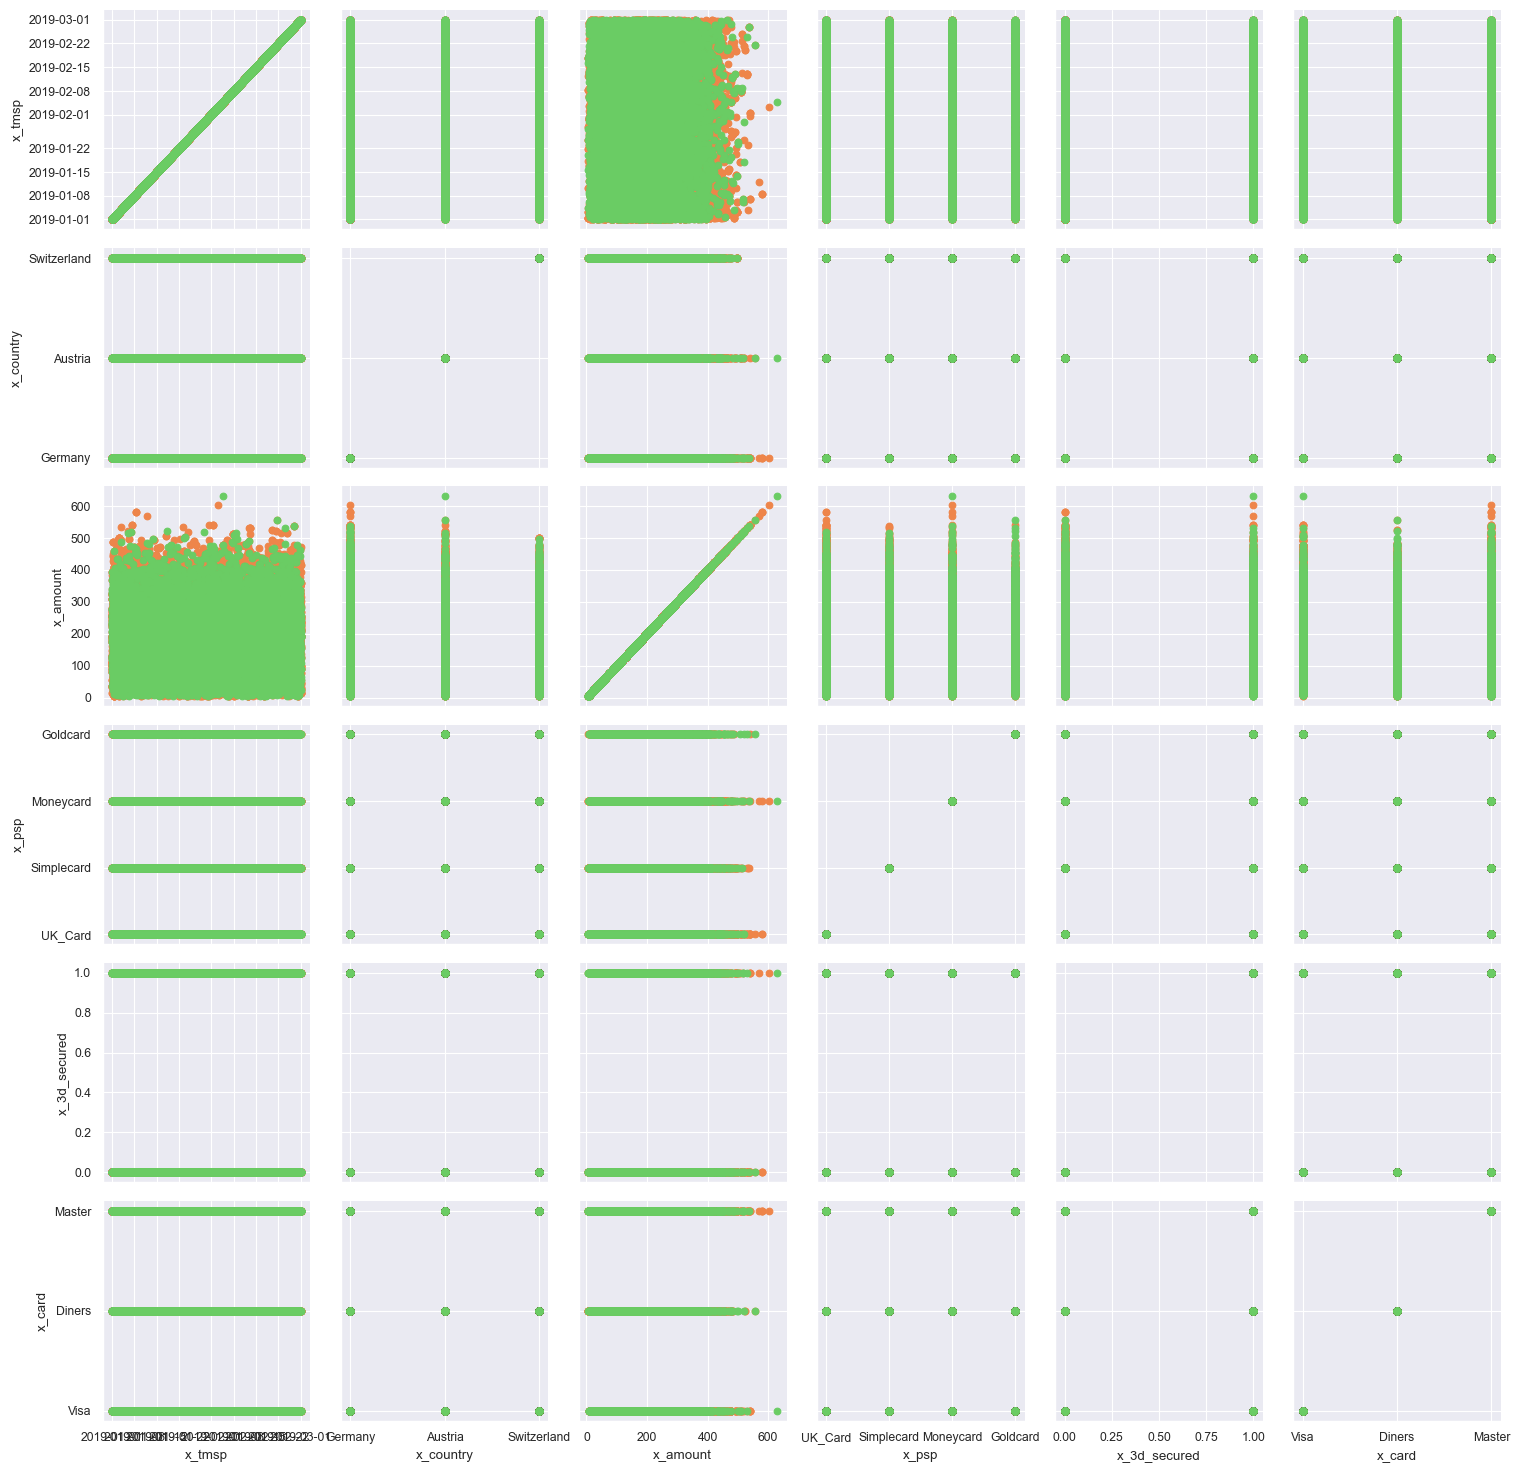

In [23]:
corr_grid = sns.PairGrid(df_t_in, hue=y_raw[0], palette=palette_success, vars=x_raw)
corr_grid.map(plt.scatter)
plt.show()

## Verify data quality
Datenqualität ist gut:
- keine fehlenden Werte
- alle Werte stimmen mit dem erwarteten Datenformat überein

# Data preparation

## Select and clean data
Evtl. Bereinigung der Outliers?

## Construct data
- Mehrfachversuche identifizieren
- Werte kodieren

### Mehrfachversuche identifizieren
Überweisungen werden als mehrfache Zahlungsversuche gezählt, wenn:
- im selben Land
- mit demselben Überweisungsbetrag
- und innerhalb derselben Minute

In [25]:
# sort to get correct order and reset index
df_t_processed = (df_t_in
                  .sort_values(by=["x_country", "x_amount", "x_tmsp"], ascending=True, inplace=False)
                  .reset_index()
                  .drop(columns=["Unnamed: 0"]))

# calculate timedifference between to consecutive rows and convert to minutes
df_t_processed["time_diff_min"] = df_t_processed["x_tmsp"].diff(periods=1).dt.total_seconds().div(60)

# init lists
cust_transaction_id = [] # from customer perspective: ID for each transaction ; can consist of several attempts
cust_attempt_no = [] # from customer perspective: no. of attempts for each transaction
psp_transaction_id = [] # from PSP perspective: ID for each transaction ; can consist of several attempts
psp_attempt_no = [] # from PSP perspective: no. of attempts for each transaction

# iter over dataframe
for idx, row in df_t_processed.iterrows():
    if (idx == 0):
        # first rows -> new transaction
        cust_transaction_id.append(0)
        cust_attempt_no.append(1)
        psp_transaction_id.append(0)
        psp_attempt_no.append(1)
    else: # not first row
        country_curr = df_t_processed.at[idx, "x_country"]
        country_prev = df_t_processed.at[idx-1, "x_country"]
        amount_curr = df_t_processed.at[idx, "x_amount"]
        amount_prev = df_t_processed.at[idx-1, "x_amount"]
        timediff = df_t_processed.at[idx, "time_diff_min"]
        psp_curr = df_t_processed.at[idx, "x_psp"]
        psp_prev = df_t_processed.at[idx-1, "x_psp"]
    
        if (country_curr == country_prev) and (amount_curr == amount_prev) and (timediff <= 60):
            # similar attempt happened already -> same transaction + new attempt
            cust_transaction_id.append(cust_transaction_id[-1])
            cust_attempt_no.append(cust_attempt_no[-1]+1) # take last entry and add 1
            
            # from PSP perspective
            if (psp_curr == psp_prev):
                # same PSP transaction -> new attempt
                psp_transaction_id.append(psp_transaction_id[-1])
                psp_attempt_no.append(psp_attempt_no[-1]+1)
            else:
                # new PSP selected -> new ID and first attempt
                psp_transaction_id.append(psp_transaction_id[-1]+1)
                psp_attempt_no.append(1)
        else:
            # different attempt -> new transaction and first attempt
            cust_transaction_id.append(cust_transaction_id[-1]+1)
            cust_attempt_no.append(1)
            psp_transaction_id.append(psp_transaction_id[-1]+1)
            psp_attempt_no.append(1)

df_t_processed["meta_customer_trx_id"] = cust_transaction_id
df_t_processed["meta_customer_atpt_no"] = cust_attempt_no
df_t_processed["meta_psp_trx_id"] = psp_transaction_id
df_t_processed["meta_psp_atpt_no"] = psp_attempt_no
df_t_processed = df_t_processed.drop(columns=["time_diff_min"])

In [28]:
df_t_processed.tail(20)

,x_tmsp,x_country,x_amount,y_success,x_psp,x_3d_secured,x_card,meta_customer_trx_id,meta_customer_atpt_no,meta_psp_trx_id,meta_psp_atpt_no
50390,2019-01-18 11:09:49,Switzerland,470,1,Goldcard,0,Master,26673,1,40680,1
50391,2019-02-28 22:43:43,Switzerland,471,0,Goldcard,0,Master,26674,1,40681,1
50392,2019-01-31 12:15:56,Switzerland,473,1,Moneycard,0,Master,26675,1,40682,1
50393,2019-02-12 10:10:34,Switzerland,473,0,UK_Card,0,Diners,26676,1,40683,1
50394,2019-01-02 18:37:09,Switzerland,474,0,Simplecard,0,Master,26677,1,40684,1
50395,2019-02-05 22:13:34,Switzerland,477,0,UK_Card,1,Master,26678,1,40685,1
50396,2019-02-22 00:14:14,Switzerland,477,0,Moneycard,0,Master,26679,1,40686,1
50397,2019-02-22 00:14:32,Switzerland,477,0,UK_Card,0,Master,26679,2,40687,1
50398,2019-02-26 17:23:31,Switzerland,479,0,UK_Card,1,Diners,26680,1,40688,1
50399,2019-02-23 21:56:39,Switzerland,480,1,UK_Card,0,Diners,26681,1,40689,1


### Zeitreiheninformationen
Zusammenhang mit der Zeit:
- Stunde
- Wochentag
- Tag im Monat
- Monat

In [ ]:
df_t_processed["tmsp_h"] = df_t_processed["tmsp"].dt.hour
df_t_processed["tmsp_wd"] = df_t_processed["tmsp"].dt.dayofweek
df_t_processed["tmsp_day"] = df_t_processed["tmsp"].dt.day
df_t_processed["tmsp_month"] = df_t_processed["tmsp"].dt.month

### Encoding
One hot encoding of:
- Country
- PSP
- 3D_secured
- Card

In [ ]:
# COUNTRY
ohe_country = pd.get_dummies(df_t_processed["country"], prefix="country", prefix_sep="_", drop_first=False)

# PSP
ohe_psp = pd.get_dummies(df_t_processed["PSP"], prefix="psp", prefix_sep="_", drop_first=False)

# 3D_secured
ohe_3d_secured = pd.get_dummies(df_t_processed["3D_secured"], prefix="3d_secured", prefix_sep="_", drop_first=False)

# card
ohe_card = pd.get_dummies(df_t_processed["card"], prefix="card", prefix_sep="_", drop_first=False)

In [ ]:
ohe_card.head()

In [ ]:
df_t_encoded = pd.concat(objs=[df_t_processed, ohe_country, ohe_psp, ohe_3d_secured, ohe_card], axis=1, ignore_index=False)

# Data understanding 2

In [ ]:
# x- and y-variables
x_all = list(df_t_encoded.columns)
y = "success"

In [ ]:
df_t_encoded.info()